<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/modeling_WESAD_all_subjects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:


# Load pickled data

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import pickle
import pandas as pd
import numpy as np

#! cd /content/drive/MyDrive/stress-prediction/ # Main file directory for this notebook on Google Drive
os.chdir('/content/drive/MyDrive/stress-prediction')
# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

import joblib
data = joblib.load(f"{PATH}/pickle/WESAD_model_data.pickle") # read pickle file
#labels = joblib.load(f"{PATH}/pickle/WESAD_labels_model.pickle") # read pickle file

Mounted at /content/drive


In [ ]:
def plot_evaluation(model, file_name):
    '''
    Plotting helper function.
    Plots the Training and validation accuracy
    as well as the training and validation loss
    over the number of epochs specified
    '''
    # Import libraries
    import matplotlib.pyplot as plt
    
    acc = model.history['binary_accuracy']
    val_acc = model.history['val_binary_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(1, 2, figsize=(24 , 8))
    ax[0].plot(epochs_range, acc, 'g-', label='Training Accuracy')
    ax[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].title.set_text('Training and Validation Accuracy')

    ax[1].plot(epochs_range, loss, 'g-', label='Training Loss')
    ax[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
    ax[1].legend(loc='upper right')
    ax[1].title.set_text('Training and Validation Loss')
    fig.patch.set_facecolor('white')
    plt.savefig(f'{file_name}')
    plt.show()

In [ ]:
def evaluate_model(model_filepath, history_filepath, val_data, test_data, save_plot_path):
  '''
  What does this function do?
  val_data: validation data generator
  test_data: testing data generator
  '''
  # Evaluate the model
  from tensorflow.keras.models import load_model
  import joblib

  # Load the model
  model = load_model(model_filepath)
  model_eval_val = model.evaluate(val_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  
  # Load the training fit history
  fit_history = joblib.load(history_filepath) # read pickle file

  # Make Plot of Training Fit
  plot_evaluation(fit_history, save_plot_path)

  # Print validation and testing metrics
  print(f'Validation Binary Accuracy is: {model_eval_val[1]:.2f}')
  model_eval_test = model.evaluate(test_data,
                                  use_multiprocessing=True,
                                  batch_size=batch_size)
  print(f'Testing Binary Accuracy is: {model_eval_test[1]:.2f}')
  return model, fit_history

In [ ]:
'''
engineer features that capture the patterns in your data that are relevant to 
predicting stress, you can compute statistics over different time intervals.
function compute_features that computes the mean and standard deviation of EDA 
over different time intervals using the rolling function. We then apply this 
function to each dataframe in the list using a list comprehension.
'''
# Define a function to compute features
def compute_features(df):
    # Compute the mean and standard deviation of EDA over different time intervals
    df['eda_phasic_mean_5min'] = df['EDA_Phasic'].rolling(window=5*60*700).mean()
    df['eda_phasic_std_5min'] = df['EDA_Phasic'].rolling(window=5*60*700).std()
    df['eda_phasic_mean_10min'] = df['EDA_Phasic'].rolling(window=10*60*700).mean()
    df['eda_phasic_std_10min'] = df['EDA_Phasic'].rolling(window=10*60*700).std()
    #df['eda_phasic_mean_30min'] = df['EDA_Phasic'].rolling(window=30*60*700).mean()
    #df['eda_phasic_std_30min'] = df['EDA_Phasic'].rolling(window=30*60*700).std()

    # Drop rows with missing values
    df.dropna(inplace=True)

    return df

# Apply the function to each dataframe in the list
data_frames_list = [compute_features(df) for df in data]


In [ ]:
# Standardize using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler to each feature
scaler = MinMaxScaler()
for i, df in enumerate(data_frames_list):
    data_frames_list[i][['eda_phasic_mean_5min', 
                         'eda_phasic_std_5min',
                         'eda_phasic_mean_10min', 
                         'eda_phasic_std_10min']] = scaler.fit_transform(df[[
                             'eda_phasic_mean_5min', 
                             'eda_phasic_std_5min',
                             'eda_phasic_mean_10min', 
                             'eda_phasic_std_10min']])
# 'eda_phasic_mean_30min', 'eda_phasic_std_30min'  'eda_phasic_mean_30min', 'eda_phasic_std_30min'
                         
                         

In [ ]:
# Train Test Split and downsampling
import pandas as pd
from sklearn.model_selection import train_test_split

for i, df in enumerate(data_frames_list):
    df['subject'] = i

# Concatenate the dataframes together
df = pd.concat(data_frames_list)

# Downsample the dataframe
target_hz = 4
resample_factor = int(700 / target_hz)
df = df.iloc[::resample_factor, :]

# Split the data into training, testing, and validation sets by subject
train_dfs = []
test_dfs = []
val_dfs = []

for i, group in df.groupby('subject'):
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.25, random_state=42)
    
    train_dfs.append(train)
    test_dfs.append(test)
    val_dfs.append(val)

train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)
val_df = pd.concat(val_dfs)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define batch size and sequence length
hz_eda = 4
duration = 5
batch_size = 64
seq_length = hz_eda * 60* duration

# Extract values from DataFrame
train_data = train_df.values
val_data = val_df.values
test_data = test_df.values

'''
# Pad sequences to make them all the same length
train_data_padded = pad_sequences(train_data, maxlen=seq_length, 
                                  dtype='float32', padding='post',
                                  truncating='post')

val_data_padded = pad_sequences(val_data, maxlen=seq_length, 
                                dtype='float32', padding='post',
                                truncating='post')

test_data_padded = pad_sequences(test_data, maxlen=seq_length, 
                                 dtype='float32', padding='post',
                                 truncating='post')
'''

# Create training data generator
train_gen = TimeseriesGenerator(train_data, train_df['labels'].values, 
                                length=seq_length, batch_size=batch_size)

val_gen = TimeseriesGenerator(val_data, val_df['labels'].values, 
                              length=seq_length, batch_size=batch_size)

test_gen = TimeseriesGenerator(test_data, test_df['labels'].values, 
                               length=seq_length, batch_size=batch_size)

'''
val_labels_padded = pad_sequences([[label] for label in val_df['labels'].tolist()], 
                                  maxlen=seq_length, 
                                  dtype='int32', padding='post', 
                                  truncating='post')

test_labels_padded = pad_sequences([[label] for label in test_df['labels'].tolist()], 
                                   maxlen=seq_length, 
                                   dtype='int32', padding='post', 
                                   truncating='post')
'''

"\nval_labels_padded = pad_sequences([[label] for label in val_df['labels'].tolist()], \n                                  maxlen=seq_length, \n                                  dtype='int32', padding='post', \n                                  truncating='post')\n\ntest_labels_padded = pad_sequences([[label] for label in test_df['labels'].tolist()], \n                                   maxlen=seq_length, \n                                   dtype='int32', padding='post', \n                                   truncating='post')\n"

In [ ]:
# get the first batch of data
x_batch, y_batch = test_gen[0]

# check the shape of the input batch
print(x_batch.shape)

(64, 1200, 7)


In [ ]:
# Callbacks Function
def callbacks(checkpoint_file, patience=3):

  # import necessary libraries
  from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

  # Callback and Early Stopping
  callbacks = [EarlyStopping(monitor='val_loss', 
                             verbose=1, 
                             patience=patience,
                             restore_best_weights=True,
                             mode='min'
                             ),
              ModelCheckpoint(checkpoint_file, 
                              save_best_only=True,
                              verbose=0
                              ),
              TensorBoard(log_dir='./logs', histogram_freq=1, 
                          embeddings_freq=1, 
                          update_freq='epoch')
  ]
  return callbacks

In [ ]:
'''
Model_0: Densely Connected Network
This neural network starts by flattening the data dn then runs it through two 
Dense layers.

This is a simple and cheap model to test the data generator and the metrics
being used to evaluate.
'''

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Flatten

# Build Model 0
inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
x = Flatten()(inputs)
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)
model_0 = keras.Model(inputs, outputs, name='model_0')

# Compile Model 0
model_0.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.001), 
              metrics=['binary_accuracy'])


model_0.summary()

Model: "model_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1200, 7)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 8400)              0         
                                                                 
 dense_4 (Dense)             (None, 64)                537664    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 537,729
Trainable params: 537,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Parameters for fitting and saving model training data
#import datetime as dt
#now = dt.datetime.now()
epochs = 200
model_0_filepath = 'models/model_dense.keras'
history_0_filepath = 'models/trainHistoryDict/model_0_dense_history.pkl'

In [ ]:
# Fit the model to the training data
history_0 = model_0.fit(train_gen, validation_data=val_gen,
                        shuffle=True, epochs=epochs, 
                        callbacks=callbacks(model_0_filepath,
                                            patience=3),
                        # remove the last batch because not even
                        steps_per_epoch=len(train_gen)-1)

# Pickle the Traning Fit History
with open(history_0_filepath, 'wb') as file_pi:
    pickle.dump(history_0.history, file_pi)

Epoch 1/200
2901/2901 [==============================] - 26s 9ms/step - loss: 1.9798 - binary_accuracy: 0.8715 - val_loss: 1.9666 - val_binary_accuracy: 0.8725
Epoch 2/200
2901/2901 [==============================] - 20s 7ms/step - loss: 1.9649 - binary_accuracy: 0.8726 - val_loss: 1.9666 - val_binary_accuracy: 0.8725
Epoch 3/200
2901/2901 [==============================] - 20s 7ms/step - loss: 1.9654 - binary_accuracy: 0.8726 - val_loss: 1.9666 - val_binary_accuracy: 0.8725
Epoch 4/200
2901/2901 [==============================] - 20s 7ms/step - loss: 1.9645 - binary_accuracy: 0.8726 - val_loss: 1.9666 - val_binary_accuracy: 0.8725
Epoch 4: early stopping


955/955 [==============================] - 10s 10ms/step - loss: 1.9666 - binary_accuracy: 0.8725


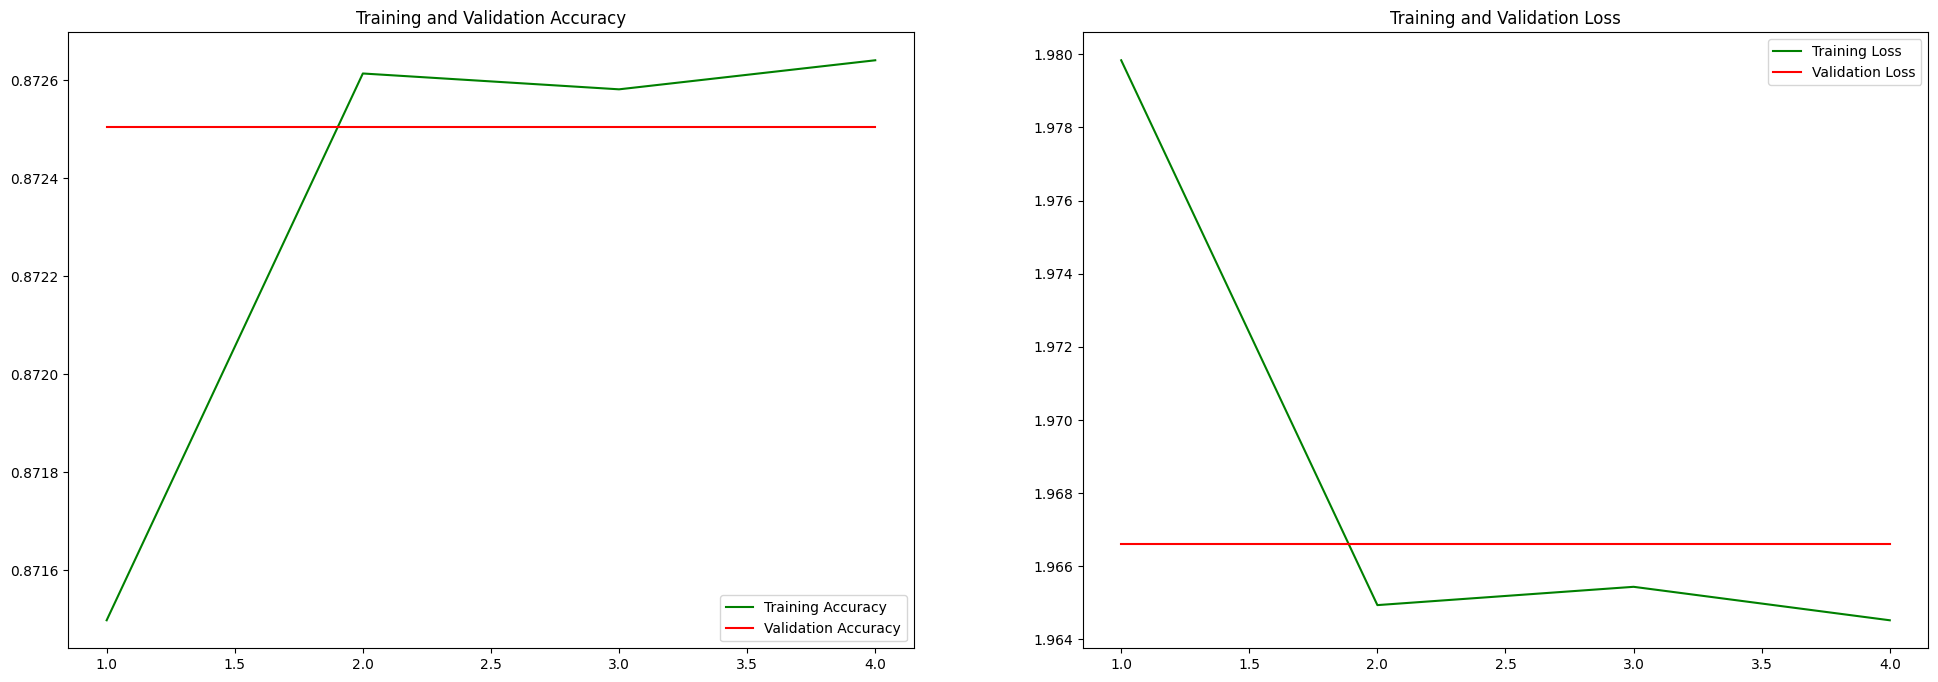

Validation Binary Accuracy is: 0.87
955/955 [==============================] - 10s 10ms/step - loss: 1.9956 - binary_accuracy: 0.8706
Testing Binary Accuracy is: 0.87


In [ ]:
# Load and Evaluate Model
model_0, history_0 = evaluate_model(model_0_filepath, 
                         history_0_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_0_evaluation.pdf')

In [ ]:
print(train_gen[0][0].shape) # prints the batch size of the first entry
'''
A tensor of shape (64, 1200, 9) means that it is a 3-dimensional tensor with 32 
rows, 1200 columns and 1 channel. In this specific case, it could represent a 
batch of 32 time series samples, each with 1200 time steps and 1 feature/channel.

The first dimension (64) represents the batch size, which is the number of 
samples that are processed at once during training. The second dimension (1200) 
represents the time steps or the sequence length of each sample, and the third 
dimension (9) represents the number of features or channels in each sample, 
8 for the features and 1 for the label.
'''

(64, 1200, 9)


'\nA tensor of shape (64, 1200, 9) means that it is a 3-dimensional tensor with 32 \nrows, 1200 columns and 1 channel. In this specific case, it could represent a \nbatch of 32 time series samples, each with 1200 time steps and 1 feature/channel.\n\nThe first dimension (64) represents the batch size, which is the number of \nsamples that are processed at once during training. The second dimension (1200) \nrepresents the time steps or the sequence length of each sample, and the third \ndimension (9) represents the number of features or channels in each sample, \n8 for the features and 1 for the label.\n'

In [ ]:
# Naive Model
def evaluate_naive_method(dataset):
  '''
  This method uses a common-sense approach to predict that the subject will be
  in the same state 5 minutes from now as they are in now.
  '''
  

In [ ]:
'''
Model_1: Simple LSTM Model
Timeseries data is a sequence, where causality and sequence matter.
'''
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

lstm_units = 128

inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
#x = LSTM(batch_size, activation='relu', input_shape=(seq_length, train_gen[0][0].shape[2]))(inputs)
x = LSTM(units=lstm_units, activation='relu', recurrent_dropout=0.5)(inputs) # Dropout)(inputs)
outputs = Dense(1, activation='sigmoid')(x)          
model_1 = keras.Model(inputs, outputs, name='model_1')

model_1.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.000001), 
              metrics=['binary_accuracy'])

# View model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1200, 7)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 128)               69632     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_1_filepath = 'models/model_1_lstm.keras'
history_1_filepath = 'models/trainHistoryDict/model_1_lstm_history.pkl'

In [ ]:
# Fit the model to the training data
history_1 = model_1.fit(train_gen, validation_data=val_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_1_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_1_filepath, 'wb') as file_pi:
    pickle.dump(history_1, file_pi)

NameError: ignored

955/955 [==============================] - 230s 240ms/step - loss: 0.4374 - binary_accuracy: 0.8725


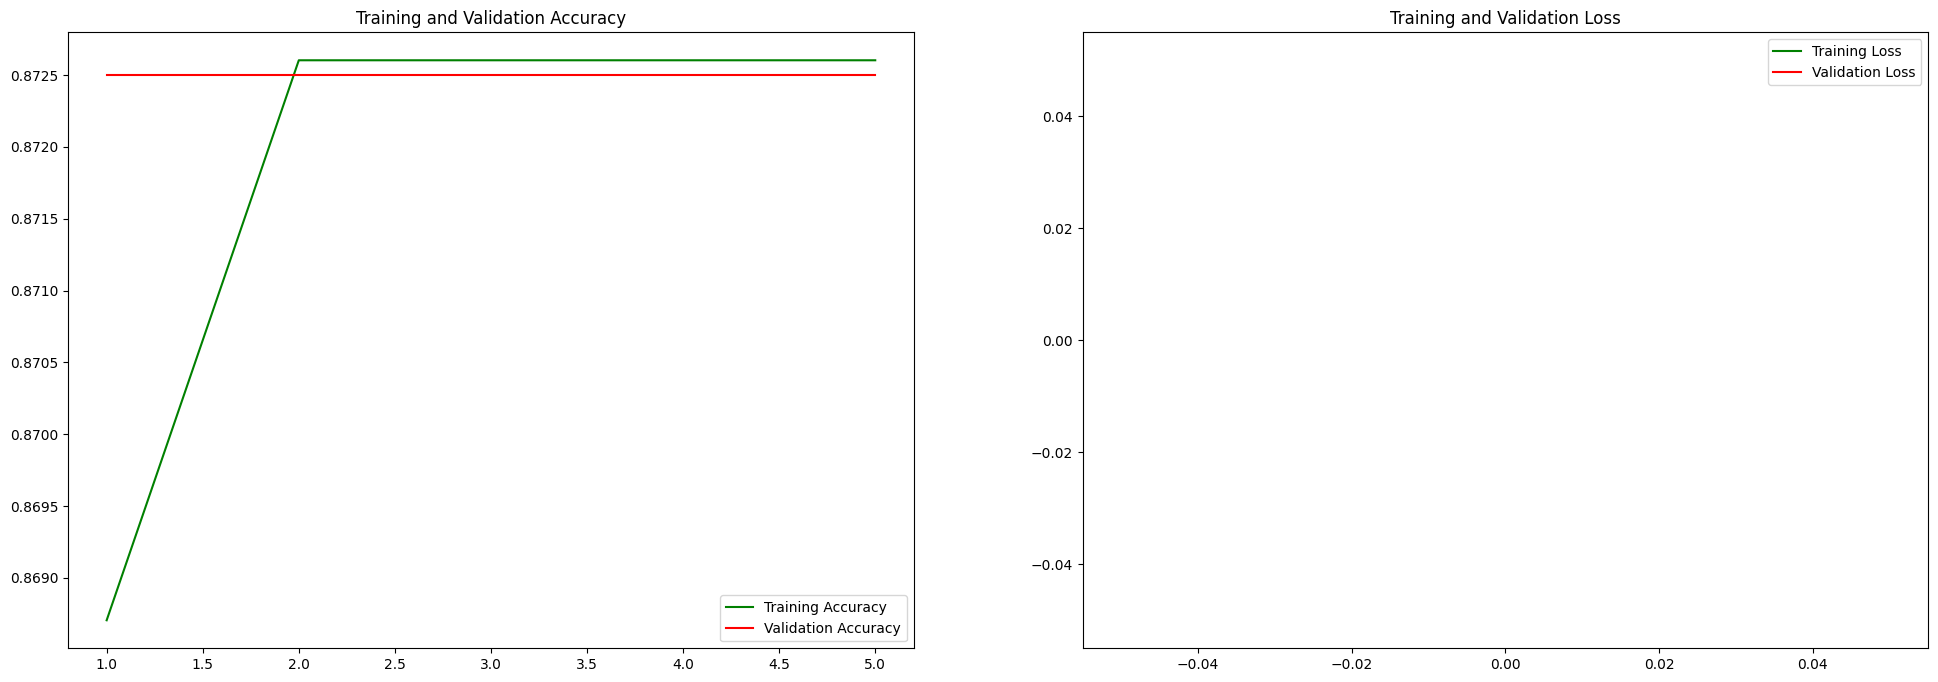

Validation Binary Accuracy is: 0.87
955/955 [==============================] - 244s 255ms/step - loss: 0.4385 - binary_accuracy: 0.8706
Testing Binary Accuracy is: 0.87


In [ ]:
# Load and Evaluate Model
model_1, history_1 = evaluate_model(model_1_filepath, 
                         history_1_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_1_evaluation.pdf')

Binary_accuracy and validation loss is stalling out around epoch 6-8. 

In [ ]:
'''
Model 2: Complex LSTM with Dropout
'''
import keras
from keras.layers import LSTM, Dense, Dropout, Reshape, RepeatVector, TimeDistributed, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam

# Build the model
inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

# LSTM layer
x = LSTM(64, 
         activation='relu', 
         input_shape=(seq_length, train_gen[0][0].shape[2]),
         return_sequences=True,
         recurrent_dropout=0.5)(inputs) # Dropout
# Second LSTM Layer
x = LSTM(32, 
         activation='relu', 
         return_sequences=True,
         recurrent_dropout=0.5)(x) # Dropout
# Use TimeDistributed to apply the same Dense layer independently to each 
# time step
x = TimeDistributed(Dense(1, activation='sigmoid'))(x)
# Flatten the output to a 1D vector
outputs = Flatten()(x)

model_2 = keras.Model(inputs, outputs, name='model_2')

# Compile
model_2.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(learning_rate=0.0001), 
              metrics=['binary_accuracy'])

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1200, 7)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 1200, 64)          18432     
                                                                 
 lstm_3 (LSTM)               (None, 1200, 32)          12416     
                                                                 
 time_distributed_1 (TimeDis  (None, 1200, 1)          33        
 tributed)                                                       
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_______________________________________________________

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_2_filepath = 'models/model_2_multiLSTM.keras'
history_2_filepath = 'models/trainHistoryDict/model_2_dense_history.pkl'

In [ ]:
# Fit the model to the training data
history_2 = model_2.fit(train_gen, validation_data=val_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_2_filepath,
                                            patience=3))

# Pickle the Traning Fit History
with open(history_2_filepath, 'wb') as file_pi:
    pickle.dump(history_2, file_pi)

Epoch 1/200
2902/2902 [==============================] - 4349s 1s/step - loss: 0.3890 - binary_accuracy: 0.8726 - val_loss: 0.4151 - val_binary_accuracy: 0.8725
Epoch 2/200
2902/2902 [==============================] - 4377s 2s/step - loss: 0.3828 - binary_accuracy: 0.8726 - val_loss: 0.3961 - val_binary_accuracy: 0.8725
Epoch 3/200
2902/2902 [==============================] - 4322s 1s/step - loss: 0.3818 - binary_accuracy: 0.8726 - val_loss: 0.3887 - val_binary_accuracy: 0.8725
Epoch 4/200
2902/2902 [==============================] - 4330s 1s/step - loss: 0.3814 - binary_accuracy: 0.8726 - val_loss: 0.3854 - val_binary_accuracy: 0.8725
Epoch 5/200
2902/2902 [==============================] - 4245s 1s/step - loss: 0.3813 - binary_accuracy: 0.8726 - val_loss: 0.3837 - val_binary_accuracy: 0.8725
Epoch 6/200
 162/2902 [>.............................] - ETA: 1:04:24 - loss: 0.4225 - binary_accuracy: 0.8513

KeyboardInterrupt: ignored

955/955 [==============================] - 282s 294ms/step - loss: 0.3837 - binary_accuracy: 0.8725


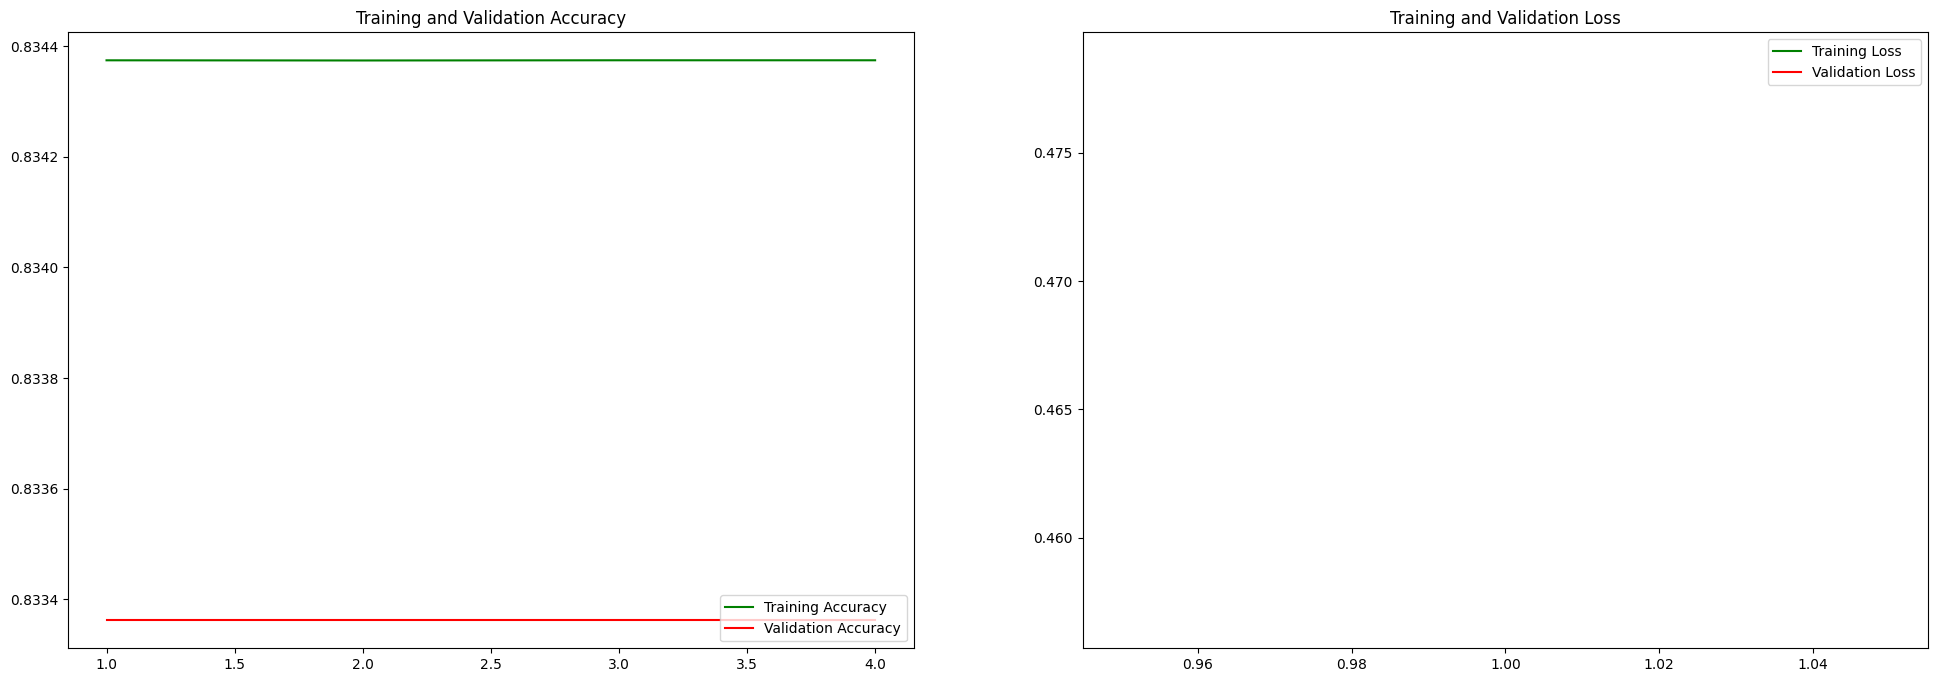

Validation Binary Accuracy is: 0.87
955/955 [==============================] - 287s 300ms/step - loss: 0.3869 - binary_accuracy: 0.8706
Testing Binary Accuracy is: 0.87


In [ ]:
# Load and Evaluate Model
model_2, history_2 = evaluate_model(model_2_filepath, 
                         history_2_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_2_evaluation.pdf')

In [ ]:
# Model 5: CNN with LSTM
import keras
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam

# Define the input shape
inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))

# Add a 1D convolutional layer to extract features
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)

# Add a LSTM layer
x = LSTM(64, activation='relu', return_sequences=True)(x)

# Add a Dense layer
x = Dense(32, activation='relu')(x)

# Flatten the output
x = Flatten()(x)

# Add a Dropout layer
x = Dropout(0.5)(x)

# Add the output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model_5 = keras.Model(inputs=inputs, outputs=outputs, name='model_5')

# Compile the model
model_5.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.0001), metrics=['binary_accuracy'])
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1200, 7)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1200, 64)          1408      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 600, 64)          0         
 )                                                               
                                                                 
 lstm_4 (LSTM)               (None, 600, 64)           33024     
                                                                 
 dense_2 (Dense)             (None, 600, 32)           2080      
                                                                 
 flatten_1 (Flatten)         (None, 19200)             0         
                                                           

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_5_filepath = 'models/model_5_multiLSTM.keras'
history_5_filepath = 'models/trainHistoryDict/model_5_dense_history.pkl'

In [ ]:
# Fit the model to the training data
history_5 = model_5.fit(train_gen, validation_data=val_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_5_filepath,
                                            patience=3))

# Pickle the Traning Fit History
with open(history_5_filepath, 'wb') as file_pi:
    pickle.dump(history_5, file_pi)

Epoch 1/200
2902/2902 [==============================] - 1027s 353ms/step - loss: 0.3834 - binary_accuracy: 0.8724 - val_loss: 0.3894 - val_binary_accuracy: 0.8725
Epoch 2/200
2902/2902 [==============================] - 1021s 352ms/step - loss: 0.3821 - binary_accuracy: 0.8726 - val_loss: 0.3847 - val_binary_accuracy: 0.8725
Epoch 3/200
2902/2902 [==============================] - 1032s 356ms/step - loss: 0.3817 - binary_accuracy: 0.8726 - val_loss: 0.3861 - val_binary_accuracy: 0.8725
Epoch 4/200
2902/2902 [==============================] - 1047s 361ms/step - loss: 0.3815 - binary_accuracy: 0.8726 - val_loss: 0.3876 - val_binary_accuracy: 0.8725
Epoch 5/200
2902/2902 [==============================] - 975s 336ms/step - loss: 0.3812 - binary_accuracy: 0.8726 - val_loss: 0.3835 - val_binary_accuracy: 0.8725
Epoch 6/200
2902/2902 [==============================] - 922s 318ms/step - loss: 0.3812 - binary_accuracy: 0.8726 - val_loss: 0.3850 - val_binary_accuracy: 0.8725
Epoch 7/200
2902/2

955/955 [==============================] - 119s 124ms/step - loss: 0.3835 - binary_accuracy: 0.8725


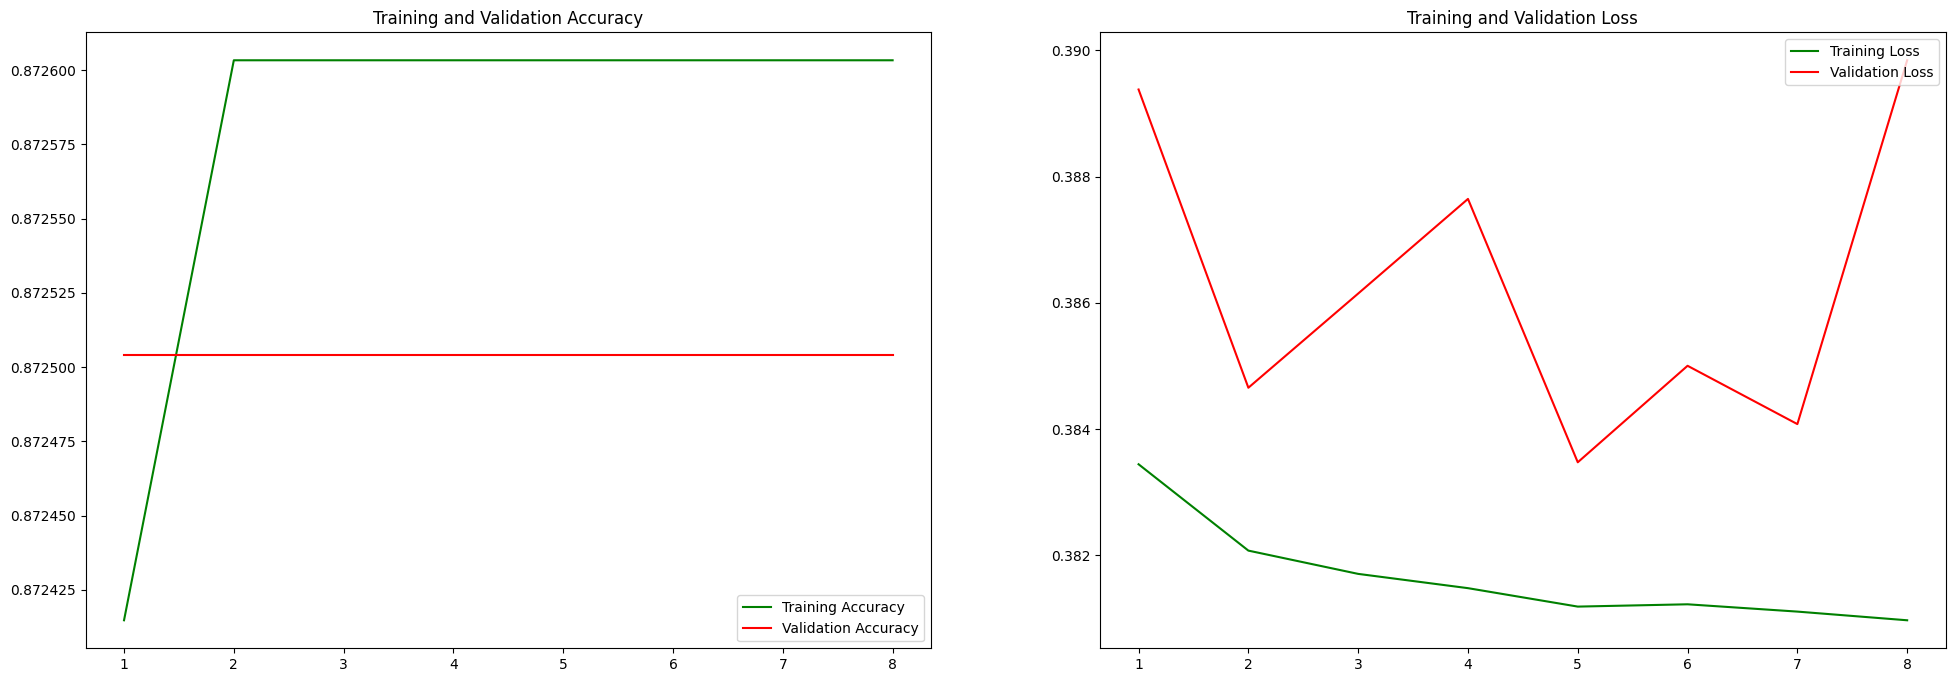

Validation Binary Accuracy is: 0.87
955/955 [==============================] - 120s 125ms/step - loss: 0.3872 - binary_accuracy: 0.8706
Testing Binary Accuracy is: 0.87


In [ ]:
# Load and Evaluate Model
model_5, history_5 = evaluate_model(model_5_filepath, 
                         history_5_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_5_evaluation.pdf')


In [ ]:
''''
Model 3: Bidirectional LSTM
'''
import keras
from keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam

# Define the LSTM model
inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
# Next model add a Dense layer here
x = Dense(units=batch_size, activation='relu')(inputs)
x = Bidirectional(LSTM(batch_size, 
                        activation='relu', 
                        #input_shape=(seq_length, 1),
                        recurrent_dropout=0.5))(x)
x = Dense(units=batch_size//2, activation='relu')(x)
outputs = Dense(units=1, activation='sigmoid')(x)
model_3 = keras.Model(inputs, outputs, name="model_3")

# Compile
model_3.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.00001), 
              metrics=['binary_accuracy'])
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1200, 7)]         0         
                                                                 
 dense_7 (Dense)             (None, 1200, 64)          512       
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 70,721
Trainable params: 70,721
Non-trainable params: 0
_______________________________________________________

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_3_filepath = 'models/model_3_bidirLSTM.keras'
history_3_filepath = 'models/trainHistoryDict/model_3_bidirLSTM_history.pkl'

In [ ]:
# Fit the model to the training data
history_3 = model_3.fit(train_gen, validation_data=val_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_3_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_3_filepath, 'wb') as file_pi:
    pickle.dump(history_3, file_pi)

Epoch 1/200
  90/2902 [..............................] - ETA: 45:06 - loss: 0.7098 - binary_accuracy: 0.1595

KeyboardInterrupt: ignored

In [ ]:

# Load and Evaluate Model
model_3, history_3 = evaluate_model(model_3_filepath, 
                         history_3_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_3_evaluation.pdf')

OSError: ignored

In [ ]:
'''
Model_4: Timeseries classification with a transformer model
Attention is all you need.
'''
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Transformer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, 
                                  num_heads=num_heads, 
                                  dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_transformer_model(
    input_shape,
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=(seq_length, train_gen[0][0].shape[2]))
    #inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

# Build model
model_4 = build_transformer_model(
                seq_length,
                n_classes=1,
                head_size=256,
                num_heads=4, # Number of Transformer repeats
                ff_dim=4,
                num_transformer_blocks=4,
                mlp_units=[128],
                mlp_dropout=0.4,
                dropout=0.25,
)

# Compile Model
model_4.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["binary_accuracy"],
)
model_4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1200, 7)]    0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 1200, 7)     14          ['input_10[0][0]']               
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 1200, 7)     31751       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [ ]:
# Parameters for fitting and saving model training data
epochs = 200
model_4_filepath = 'models/model_4_transformer.keras'
history_4_filepath = 'models/trainHistoryDict/model_4_transformer_history.pkl'

In [ ]:
# Fit the model to the training data
history_4 = model_4.fit(train_gen, validation_data=val_gen,
                        shuffle=False, epochs=epochs, 
                        callbacks=callbacks(model_4_filepath,
                                            patience=5))

# Pickle the Traning Fit History
with open(history_4_filepath, 'wb') as file_pi:
    pickle.dump(history_4, file_pi)

Epoch 1/200
   3/2902 [..............................] - ETA: 17:56:50 - loss: 1.0424 - binary_accuracy: 0.3333

KeyboardInterrupt: ignored

In [ ]:
# Load and Evaluate Model
model_4, history_4 = evaluate_model(model_4_filepath, 
                         history_4_filepath,
                         val_gen, 
                         test_gen,
                         'models/evaluate/model_4_evaluation.pdf')